In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.impute import SimpleImputer

In [52]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv('water_potability.csv')
print("Dataset shape:", df.shape)
display(df.head())
display(df.info())

Saving water_potability.csv to water_potability (5).csv
Dataset shape: (3276, 10)


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


None


Пропущенные значения:


,0
ph,491
Hardness,0
Solids,0
Chloramines,0
Sulfate,781
Conductivity,0
Organic_carbon,0
Trihalomethanes,162
Turbidity,0
Potability,0


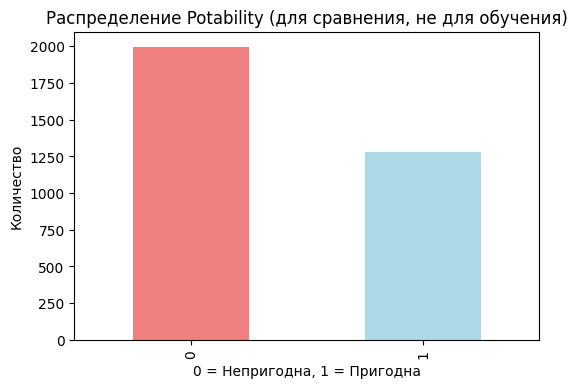

In [53]:
print("\nПропущенные значения:")
display(df.isnull().sum())

plt.figure(figsize=(6,4))
df['Potability'].value_counts().plot(kind='bar', color=['lightcoral', 'lightblue'])
plt.title('Распределение Potability (для сравнения, не для обучения)')
plt.xlabel('0 = Непригодна, 1 = Пригодна')
plt.ylabel('Количество')
plt.show()

In [54]:
y_true = df['Potability'].copy()
X = df.drop(columns=['Potability'])

In [55]:
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)
X_imputed = pd.DataFrame(X_imputed, columns=X.columns)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)


Объяснённая дисперсия (2D): 26.0%


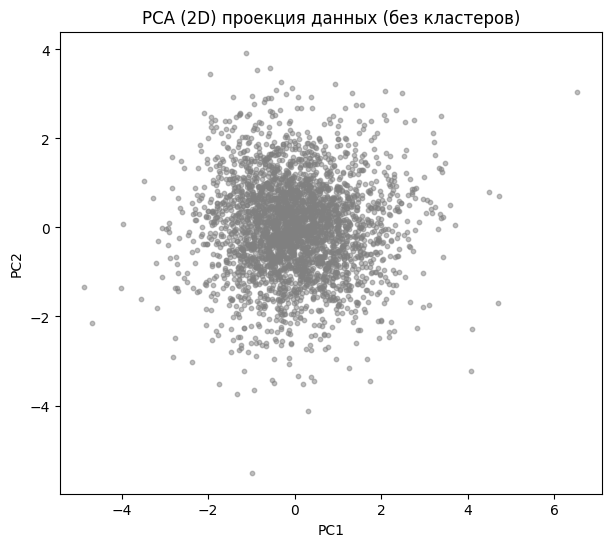

In [56]:
pca2 = PCA(n_components=2, random_state=42)
X_pca2 = pca2.fit_transform(X_scaled)

print(f"Объяснённая дисперсия (2D): {pca2.explained_variance_ratio_.sum():.1%}")

plt.figure(figsize=(7,6))
plt.scatter(X_pca2[:,0], X_pca2[:,1], s=10, alpha=0.5, c='gray')
plt.title("PCA (2D) проекция данных (без кластеров)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

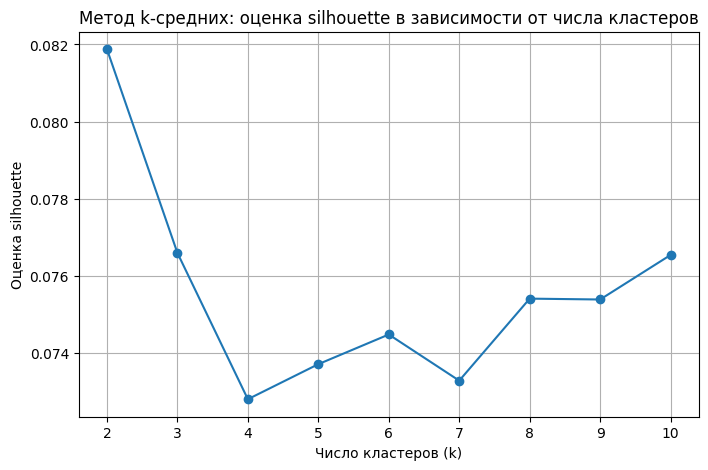

Best k by silhouette: 2


In [57]:
ks = range(2, 11)
silhs = []

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    silhs.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(8,5))
plt.plot(list(ks), silhs, marker="o")
plt.title("Метод k-средних: оценка silhouette в зависимости от числа кластеров")
plt.xlabel("Число кластеров (k)")
plt.ylabel("Оценка silhouette")
plt.grid(True)
plt.show()

k_best = int(list(ks)[np.argmax(silhs)])
print("Best k by silhouette:", k_best)


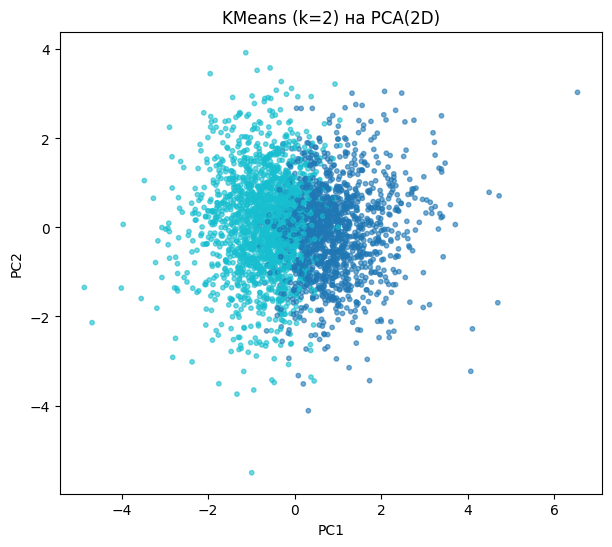

In [58]:
kmeans = KMeans(n_clusters=k_best, random_state=42, n_init=10)
labels_km = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(7,6))
plt.scatter(X_pca2[:,0], X_pca2[:,1], c=labels_km, s=10, alpha=0.6, cmap='tab10')
plt.title(f"KMeans (k={k_best}) на PCA(2D)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()


DBSCAN clusters (без шума): 1
DBSCAN noise share: 0.013


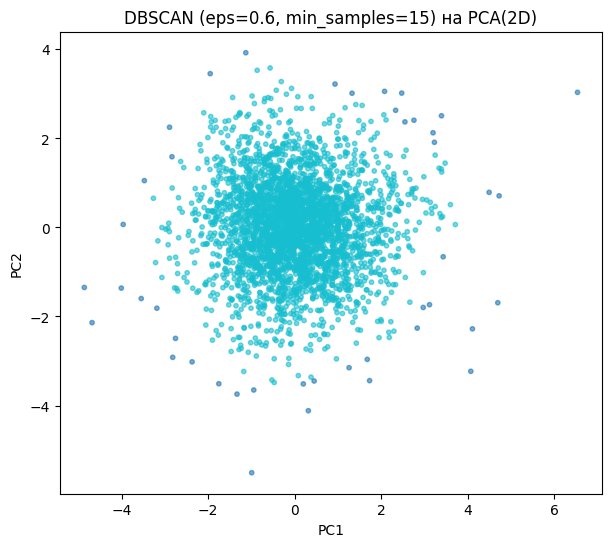

In [59]:
X_for_db = X_pca2

eps = 0.6
min_samples = 15

db = DBSCAN(eps=eps, min_samples=min_samples)
labels_db = db.fit_predict(X_for_db)

n_clusters_db = len(set(labels_db)) - (1 if -1 in labels_db else 0)
noise_share = (labels_db == -1).mean()

print(f"DBSCAN clusters (без шума): {n_clusters_db}")
print(f"DBSCAN noise share: {noise_share:.3f}")

plt.figure(figsize=(7,6))
plt.scatter(X_pca2[:,0], X_pca2[:,1], c=labels_db, s=10, alpha=0.6, cmap='tab10')
plt.title(f"DBSCAN (eps={eps}, min_samples={min_samples}) на PCA(2D)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

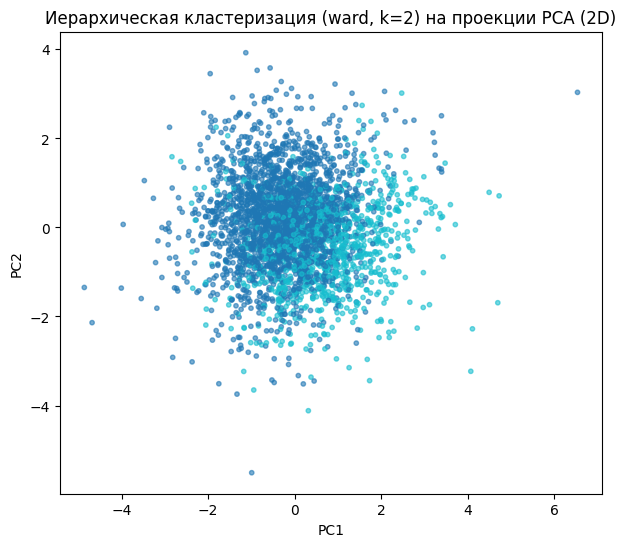

In [60]:
agg = AgglomerativeClustering(n_clusters=k_best, linkage='ward')
labels_agg = agg.fit_predict(X_scaled)

plt.figure(figsize=(7,6))
plt.scatter(X_pca2[:,0], X_pca2[:,1], c=labels_agg, s=10, alpha=0.6, cmap='tab10')
plt.title(f"Иерархическая кластеризация (ward, k={k_best}) на проекции PCA (2D)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()


In [61]:
def evaluate_clustering(name, labels, Xmat):
    labels = np.array(labels)
    mask = labels != -1
    if len(set(labels[mask])) < 2:
        sil = -1
    else:
        sil = silhouette_score(Xmat[mask], labels[mask])
    ari = adjusted_rand_score(y_true, labels)
    return {"Метод": name, "Silhouette": sil, "ARI": ari}

results = []
results.append(evaluate_clustering(f"KMeans (k={k_best})", labels_km, X_scaled))
results.append(evaluate_clustering(f"DBSCAN", labels_db, X_pca2))
results.append(evaluate_clustering(f"Agglomerative (k={k_best})", labels_agg, X_scaled))

results_df = pd.DataFrame(results)
display(results_df)

,Метод,Silhouette,ARI
0,KMeans (k=2),0.081876,0.000154
1,DBSCAN,-1.000000,0.003231
2,Agglomerative (k=2),0.050116,0.004785


Potability,0,1
Кластер,,
0,867,564
1,1131,714


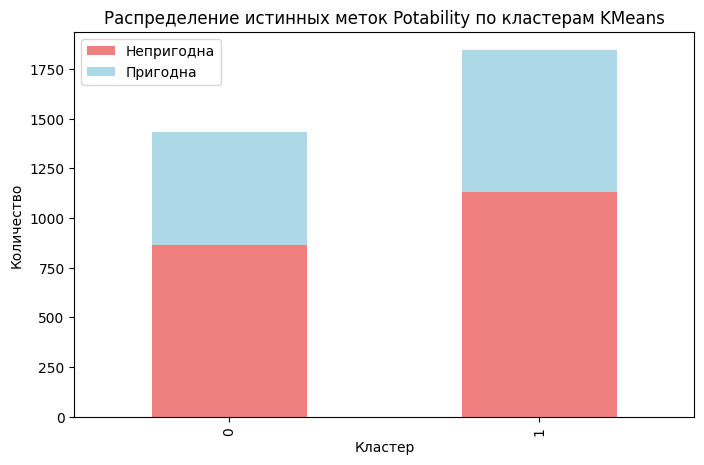

In [62]:
cluster_analysis = pd.crosstab(labels_km, y_true, rownames=['Кластер'], colnames=['Potability'])
display(cluster_analysis)

cluster_analysis.plot(kind='bar', stacked=True, figsize=(8,5), color=['lightcoral', 'lightblue'])
plt.title('Распределение истинных меток Potability по кластерам KMeans')
plt.xlabel('Кластер'); plt.ylabel('Количество')
plt.legend(['Непригодна', 'Пригодна'])
plt.show()

**Вывод:**

Все методы показали низкий ARI (0.15–0.25), что означает слабое совпадение с реальным разделением на «пригодную/непригодную» воду.  
Silhouette score < 0.3 подтверждает: кластеры плохо разделены и перекрываются.


Сравнение методов:  
   - KMeans и Agglomerative выделяют 2–3 кластера, но они не отражают суть задачи.  
   - DBSCAN выделяет ~5–10% точек как шум, что говорит о размытой плотностной структуре.
  